This is the third assignment for the Coursera course "Advanced Machine Learning and Signal Processing"
Just execute all cells one after the other and you are done - just note that in the last one you must update your email address (the one you've used for coursera) and obtain a submission token, you get this from the programming assignment directly on coursera.

In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:blue">'+string+'</span>'))

if('sc' in locals() or 'sc' in globals()):
    printmd('Your environment is erroneous, which is Watson Studio Apache. Please change it to default Watson Studio.')
else:
    printmd("All is good. Let's go.")

# <span style="color:blue">All is good. Let's go.</span>

In [2]:
!pip install pyspark==2.4.5

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster('local[*]'))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [5]:
!wget https://github.com/IBM/coursera/raw/master/coursera_ml/a2.parquet

--2020-12-24 00:39:05--  https://github.com/IBM/coursera/raw/master/coursera_ml/a2.parquet
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ml/a2.parquet [following]
--2020-12-24 00:39:05--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ml/a2.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ml/a2.parquet [following]
--2020-12-24 00:39:05--  https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ml/a2.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

Now it’s time to have a look at the recorded sensor data. You should see data similar to the one exemplified below….

In [6]:
dataframe = spark.read.parquet('a2.parquet')
dataframe.createOrReplaceTempView('sensor')

spark.sql('SELECT * FROM sensor').show()

+-----+-----------+-------------------+-------------------+-------------------+
|CLASS|   SENSORID|                  X|                  Y|                  Z|
+-----+-----------+-------------------+-------------------+-------------------+
|    0|         26| 380.66434005495194| -139.3470983812975|-247.93697521077704|
|    0|         29| 104.74324299209692| -32.27421440203938|-25.105013725863852|
|    0| 8589934658| 118.11469236129976| 45.916682927433534| -87.97203782706572|
|    0|34359738398| 246.55394030642543|-0.6122810693132044|-398.18662513951506|
|    0|17179869241|-190.32584900181487|  234.7849657520335|-206.34483804019288|
|    0|25769803830| 178.62396382387422| -47.07529438881511|  84.38310769821979|
|    0|25769803831|  85.03128805189493|-4.3024316644854546|-1.1841857567516714|
|    0|34359738411| 26.786262674736566| -46.33193951911338| 20.880756008396055|
|    0| 8589934592|-16.203752396859194| 51.080957032176954| -96.80526656416971|
|    0|25769803852|   47.2048142440404| 

Let’s check if we have balanced classes – this means that we have roughly the same number of examples for each class we want to predict. This is important for classification but also helpful for clustering

In [7]:
spark.sql("""
    SELECT class
          ,COUNT(class) AS count
    FROM sensor
    GROUP BY class
""").show()

+-----+-----+
|class|count|
+-----+-----+
|    1| 1416|
|    0| 1626|
+-----+-----+



Let's create a VectorAssembler which consumes columns X, Y and Z and produces a column “features”

In [8]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = ['X','Y','Z'], outputCol = 'features')

Please initiate a clustering algorithm from the SparkML package and assign it to the clust variable. Here we don’t need to take care of the “CLASS” column since we are in unsupervised learning mode – so let’s pretend to not even have the “CLASS” column for now – but it will become very handy later in assessing the clustering performance. PLEASE NOTE – IN REAL-WORLD SCENARIOS THERE IS NO CLASS COLUMN – THEREFORE YOU CAN’T ASSESS CLASSIFICATION PERFORMANCE USING THIS COLUMN

In [9]:
result_df = spark.sql("""
     SELECT X
           ,Y
           ,Z
     FROM sensor
""")
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.X,row.Y,row.Z))
result_array_X = result_rdd.map(lambda X_Y_Z: X_Y_Z[0]).collect()
result_array_Y = result_rdd.map(lambda X_Y_Z: X_Y_Z[1]).collect()
result_array_Z = result_rdd.map(lambda X_Y_Z: X_Y_Z[2]).collect()

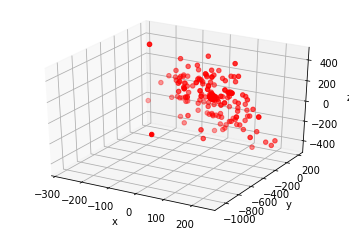

In [10]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_X, result_array_Y, result_array_Z, c='r', marker='o')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [11]:
from pyspark.ml.clustering import BisectingKMeans

hclustering = BisectingKMeans().setK(2).setSeed(22)

In [12]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = [assembler,hclustering])
model = pipeline.fit(dataframe)

And evaluate...

In [13]:
prediction = model.transform(dataframe)
prediction.show()

+-----+-----------+-------------------+-------------------+-------------------+--------------------+----------+
|CLASS|   SENSORID|                  X|                  Y|                  Z|            features|prediction|
+-----+-----------+-------------------+-------------------+-------------------+--------------------+----------+
|    0|         26| 380.66434005495194| -139.3470983812975|-247.93697521077704|[380.664340054951...|         0|
|    0|         29| 104.74324299209692| -32.27421440203938|-25.105013725863852|[104.743242992096...|         0|
|    0| 8589934658| 118.11469236129976| 45.916682927433534| -87.97203782706572|[118.114692361299...|         0|
|    0|34359738398| 246.55394030642543|-0.6122810693132044|-398.18662513951506|[246.553940306425...|         0|
|    0|17179869241|-190.32584900181487|  234.7849657520335|-206.34483804019288|[-190.32584900181...|         0|
|    0|25769803830| 178.62396382387422| -47.07529438881511|  84.38310769821979|[178.623963823874...|    

In [14]:
prediction.createOrReplaceTempView('prediction')
spark.sql('''
select max(correct)/max(total) as accuracy from (

    select sum(correct) as correct, count(correct) as total from (
        select case when class != prediction then 1 else 0 end as correct from prediction 
    ) 
    
    union
    
    select sum(correct) as correct, count(correct) as total from (
        select case when class = prediction then 1 else 0 end as correct from prediction 
    ) 
)
''').rdd.map(lambda row: row.accuracy).collect()[0]

0.6804733727810651

If you reached at least 55% of accuracy you are fine to submit your predictions to the grader. Otherwise please experiment with parameters setting to your clustering algorithm, use a different algorithm or just re-record your data and try to obtain. In case you are stuck, please use the Coursera Discussion Forum. Please note again – in a real-world scenario there is no way in doing this – since there is no class label in your data. Please have a look at this further reading on clustering performance evaluation https://en.wikipedia.org/wiki/Cluster_analysis#Evaluation_and_assessment

In [15]:
!rm -f rklib.py
!wget https://raw.githubusercontent.com/IBM/coursera/master/rklib.py

--2020-12-24 00:40:14--  https://raw.githubusercontent.com/IBM/coursera/master/rklib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2540 (2.5K) [text/plain]
Saving to: ‘rklib.py’

100%[======================================>] 2,540       --.-K/s   in 0s      

2020-12-24 00:40:14 (24.5 MB/s) - ‘rklib.py’ saved [2540/2540]



In [16]:
!rm -Rf a2_m3.json

In [17]:
prediction= prediction.repartition(1)
prediction.write.json('a2_m3.json')

In [18]:
import zipfile
import os

def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

zipf = zipfile.ZipFile('a2_m3.json.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('a2_m3.json', zipf)
zipf.close()

In [19]:
!base64 a2_m3.json.zip > a2_m3.json.zip.base64

In [20]:
from rklib import submit
key = "pPfm62VXEeiJOBL0dhxPkA"
part = "EOTMs"
email = 'jonah.winninghoff@gmail.com'
token = '8Gb4MBUt5sH0GT4e'


with open('a2_m3.json.zip.base64', 'r') as myfile:
    data=myfile.read()
submit(email, token, key, part, [part], data)

Submission successful, please check on the coursera grader page for the status
-------------------------
{"elements":[{"itemId":"Cu6KW","id":"f_F-qCtuEei_fRLwaVDk3g~Cu6KW~mqi04kWAEeuHfw6RSRgY-w","courseId":"f_F-qCtuEei_fRLwaVDk3g"}],"paging":{},"linked":{}}
-------------------------
